# <center> Inflación en Argentina </center>

Este post solo tiene como propósito difundir ideas de machine learning, ya que el análisis de inferencia causal es más complicado y requiere de técnicas diferentes a las vistas en este análisis (variables instrumentales, diferencias en diferencias, etc.)

## Introducción

Un problema de mucho tiempo, un problema muy discutido, en la radio, en la tele, en redes.... el problema de la inflación en Argentina parece no solucionarse sin importar quien haya estado al mando del país. Sin embargo, nuevas perspectivas mucho más ortodoxas han venido despertando el interés del público más joven. "Siempre y en todo lugar" la inflación es un fenómeno monetario se repite una y otra vez.

Independientemente de la escuela de economía a la que uno se suscriba o incluso si es la primera vez que se escucha del tema. El análisis de la evidencia (estadísticas y tendencias cuantificables) debería ser tomada en cuenta; el mundo real también puede opinar de nuestras teorías. Este análisis espera dejar más en claro de aquellas variables que se relacionan con la inflación en la Argentina. 

Dado que no se trata de un análisis causal, sólo pretende dar una presentación didáctica de cómo se puede desarrollar un análisis de selección de variables para un modelo de regresión, así como de las herramientas que se aplican en su realización.

Entonces, partamos de un enfoque ingenuo...

La mencionada frase "la inflación es siempre y en todas partes un fenómeno monetario" se atribuye comúnmente al economista Milton Friedman. Un economista con una fuerte línea positivista y que era partidario del utilitarismo metodológico (al menos en su trabajo "Essays in Positive Economics" de 1966). Es decir, Milton estaba muy a favor de la evidencia empírica. Esto no significa que despreciara la teoría, sólo que para alguien como Friedman la teoría debía ser probada y considerada en la medida en que explicara o predijera correctamente la realidad.

## El modelo

Entonces supongamos que no tenemos idea si la inflación es multicausal o netamente un fenómeno monetario. Simplemente consideramos que existe una variable inflacion ($\pi$) que es afectada por un conjunto de variables diferentes ($X_1, X_2, X_3 ... X_n$). Esto puede expresarse como una simple función: 
$$ \pi = f(X_1, X_2, X_3... X_n) $$
Ahora bien, uno de los vicios más comunes en la econometría es pensarlo todo como una relación lineal. Comúnmente no habría problema si existiera un análisis teórico previo, pero para este análisis dejamos atrás toda teoría. Entonces no podemos fiarnos de que las relaciones entre la inflación y el resto de las variables sean únicamente lineales. Por ello debemos estar abiertos a la utilización de cualquier otra representación de los datos que nos sea más útil.

Cuando las relaciones son desconocidas uno puede pensar en redes neuronales, eso está bien; sin embargo, las redes no permiten una alta interpretabilidad de lo que está pasando en ellas. Una forma bastante popular y que permite cierto grado de interpretación son los modelos de árboles de decisión. Y de los algoritmos basados en árboles de decision, uno de los más poderosos es el XGBOOST.

## Los datos

Una vez que se ha pensado en un modelo es importante saber conque se va a entrenar, si bien conocemos que la inflación es nuestra variable dependiente, nos falta encontrar las demás. Dado que para este análisis tomamos un punto de vista ingenuo, ¿qué tal si las probamos todas? Todas las variables económicas que se hayan tomado a la misma unidad de análisis, claro. 

Nuestra unidad de análisis es Argentina y dado que no consideramos a la inflación como un fenómeno que trastienda el tiempo, nuestra unidad de análisis es Argentina en un periodo de tiempo t. Esto puede ser útil dado que si consideramos a la inflación como un fenómeno netamente monetario "siempre y en todo lugar", nuestra suposición no deberá afectar a la estimación. Entonces, nuestras variables independientes son todas las mediciones económicas de la argentina.

Para esto se usarán datos de: 
- Banco de datos del banco mundial
- Banco de datos del FMI
- La base de datos Penn World Table.

## Manos a la obra

Empecemos con el código:

In [1]:
# Importamos las librerias necesarias
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
from sklearn.feature_selection import RFECV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor


In [2]:
# Cargamos los datos, dado que son varias bases de datos, 
# Son muchas columnas
data = pd.read_excel("C:/Users/crisd/OneDrive/Escritorio/libros/project/argentina.xlsx")

# Configuracion para visualizar los datos
pd.options.display.max_columns = 215
data.head()


,year,INF,Masa monetaria (% del PIB),Relación entre masa monetaria y reservas totales,Crecimiento de la masa monetaria (% anual),Gasto nacional bruto (% del PIB),Mercaderías importadas desde economías en desarrollo dentro de la región (% del total de mercaderías importadas),Tasa de inactividad por edades (% de la población en edad de trabajar),"Esperanza de vida al nacer, mujeres (años)",INB per cápita (US$ constantes del año 2010),PIB (UMN a precios actuales),Importaciones de bienes y servicios (UMN a precios constantes),Formación bruta de capital fijo (% del crecimiento anual),Suscripciones a telefonía fija,Población de la ciudad con más habitantes (% de la población urbana),Mercaderías exportadas hacia economías en desarrollo en Asia oriental y el Pacífico (% del total de mercaderías exportadas),Importaciones de mercaderías (US$ a precios actuales),Población urbana,"Población de 65 años de edad y más, hombres","Población de 35 a 39 años, mujeres (% de la población femenina)","Población de 10 a 14 años, mujeres (% de la población femenina)","Supervivencia hasta los 65 años, varones (% de la cohorte)",Índice de deflación del PIB (el año base varía según el país),Formación bruta de capital (UMN a precios constantes),Exportaciones de bienes y servicios (% del PIB),Exportaciones de mercaderías (US$ a precios actuales),Crecimiento de la población rural (% anual),"Tasa de inactividad por edades, personas menores de 15 años (% de la población en edad de trabajar)","Población de 65 a 69 años, varones (% de la población masculina)","Población de 25 a 29 años, varones (% de la población masculina)",Población entre 0 y 14 años de edad (% del total),"Esperanza de vida al nacer, varones (años)",Ajuste de los términos de intercambio (UMN a precios constantes),INB per cápita (moneda local constante),Ahorro interno bruto (UMN a precios actuales),PIB (US$ a precios constantes de 2010),Formación bruta de capital (UMN a precios actuales),"Total de reservas (incluye oro, US$ a precios actuales)",Mercaderías exportadas hacia economías en desarrollo en Asia meridional (% del total de mercaderías exportadas),"Población, hombres","Población de 70 a 74 años, mujeres (% de la población femenina)","Población de 45 a 49 años, mujeres (% de la población femenina)","Población entre 15 y 64 años de edad, mujeres","Tasa de natalidad, nacidos vivos en un año (por cada 1.000 personas)",INB (US$ constantes del año 2010),PIB per cápita (UMN actual),Importaciones de bienes y servicios (US$ a precios constantes de 2010),Formación bruta de capital fijo (UMN a precios actuales),Final consumption expenditure (% of GDP),Exportaciones de mercadería hacia economías en el mundo árabe (% del total de exportaciones de mercadería),Población rural,"Tasa de inactividad por edades, personas de 65 años y más (% de la población en edad de trabajar)","Población de 65 a 69 años, mujeres (% de la población femenina)","Población de 25 a 29 años, mujeres (% de la población femenina)","Población entre 0 y 14 años de edad, total","Esperanza de vida al nacer, total (años)",Crecimiento per cápita del INB (% anual),Exportaciones como capacidad para importar (UMN a precios constantes),Comercio (% del PIB),Balanza comercial de bienes y servicios (% del PIB),Cambios en inventarios (UMN a precios constantes),Gasto militar (% del PIB),Formación bruta de capital fijo (% del PIB),Gasto nacional bruto (US$ a precios constantes de 2010),Población en aglomerados urbanos > 1 millón (% de la población total),Mercaderías exportadas hacia economías en desarrollo en América Latina y el Caribe (% del total de mercaderías exportadas),Mercaderías importadas desde economías en desarrollo fuera de la región (% del total de mercaderías importadas),"Población, mujeres","Población de 65 años de edad y más, total","Población de 40 a 44 años, mujeres (% de la población femenina)","Población de 15 a 19 años, mujeres (% de la población femenina)","Tasa de mortalidad, adultos, mujeres (por cada 1.000 mujeres adult

In [3]:
# Separamos la variable de interes y las variables de caracteristicas
y = data.pop('INF')
X = data.drop('year', axis=1)

# Separamos los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.15, random_state=0, shuffle=True)


In [4]:
# Creamos el modelo, un modelo de XGBregressor básico.
model = XGBRegressor()
model.fit(X_train, y_train)


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [5]:
# Evaluamos el modelo con los datos de entrenamiento
y_pred = model.predict(X_train)
print("MSE:", mean_squared_error(y_train, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_train, y_pred)))


MSE: 1.803174758473406e-07
RMSE: 0.0004246380527547438


In [6]:
# Evaluamos el modelo con los datos de prueba
y_pred = model.predict(X_test)
print("MSE:", mean_squared_error(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))


MSE: 5539.669529241109
RMSE: 74.42895625521768


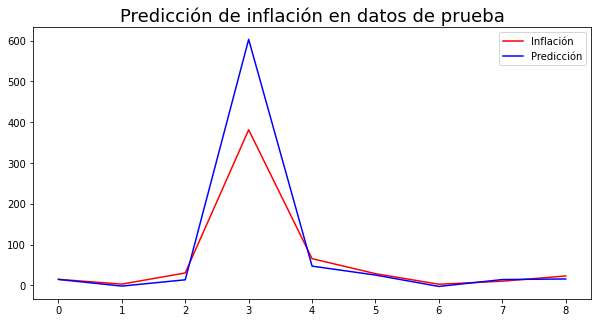

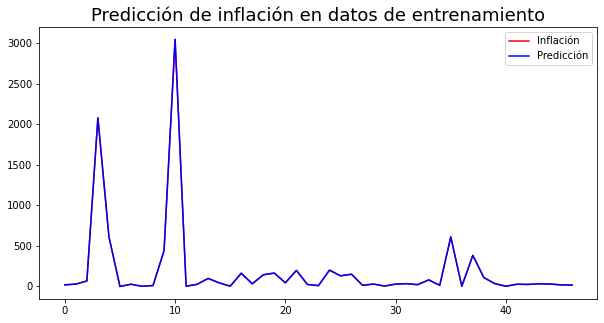

In [7]:
# Graficamos el resultado
y_pred = model.predict(X_test)
plt.figure(figsize=(10, 5))
plt.plot(range(len(y_test)), y_test, label='Inflación', color='red')
plt.plot(range(len(y_test)), y_pred, label='Predicción', color='blue')
plt.title('Predicción de inflación en datos de prueba', fontsize=18)
plt.legend()
plt.show()

y_pred = model.predict(X_train)
plt.figure(figsize=(10, 5))
plt.plot(range(len(y_train)), y_train, label='Inflación', color='red')
plt.plot(range(len(y_train)), y_pred, label='Predicción', color='blue')
plt.title('Predicción de inflación en datos de entrenamiento', fontsize=18)
plt.legend()
plt.show()


Hemos observado que el modelo es bastante bueno, revisemos la importancia de las caracteristicas.

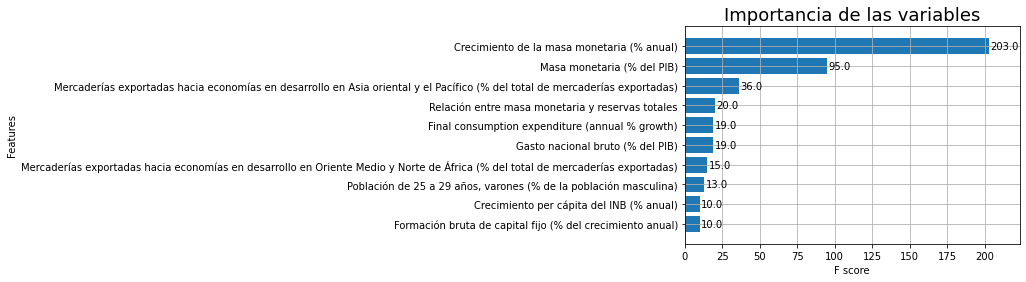

In [8]:
# Graficamos la importancia de unicamente las 10 variables que mas influyen en la predicción
xgb.plot_importance(model, max_num_features=10, height=0.8)
plt.title('Importancia de las variables', fontsize=18)
plt.show()

El gráfico muestra efectivamente que las variables que más ayudan a predecir la inflación (tanto como causa o efecto) son el crecimiento de la masa monetaria, la masa monetaria como porcentaje del PIB y las exportaciones hacia economías en desarrollo del Asia y el pacífico como porcentage del total de exportaciones. 

Para continuar con el análisis, es posible que este modelo este sesgado, dado que las variables poseen órdenes de magnitud muy distintos entre sí. Es decir, algunas variables se miden en millones y otras son apenas porcentajes. Para evitar esto se normalizarán los datos y se repetirá el modelo.

In [9]:
# Se normaliza los datos
sc = StandardScaler()

# Este tipo de escalado unicamente resta la media y divide por la desviación estandar
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# Creamos el nuevo modelo, un modelo de XGBregressor básico.
model = XGBRegressor()
model.fit(X_train, y_train)


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [10]:
# Evaluamos el modelo con los datos de entrenamiento
y_pred = model.predict(X_train)
print("MSE:", mean_squared_error(y_train, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_train, y_pred)))


MSE: 2.201400543819834e-07
RMSE: 0.00046919085070148525


In [11]:
# Evaluamos el modelo con los datos de prueba
y_pred = model.predict(X_test)
print("MSE:", mean_squared_error(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))


MSE: 5530.613526346537
RMSE: 74.3680948145543


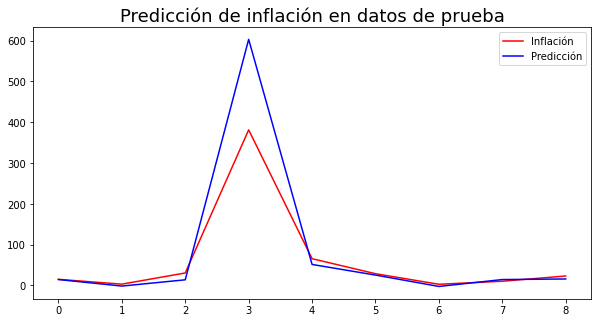

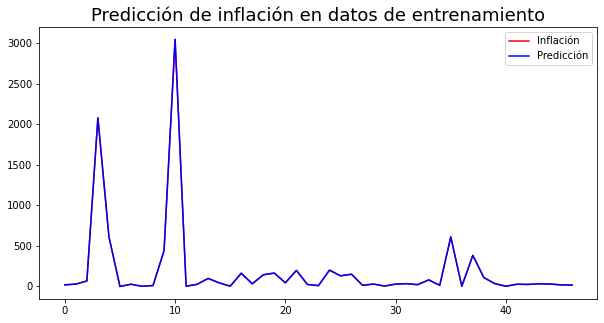

In [12]:
# Graficamos el resultado
y_pred = model.predict(X_test)
plt.figure(figsize=(10, 5))
plt.plot(range(len(y_test)), y_test, label='Inflación', color='red')
plt.plot(range(len(y_test)), y_pred, label='Predicción', color='blue')
plt.title('Predicción de inflación en datos de prueba', fontsize=18)
plt.legend()
plt.show()

y_pred = model.predict(X_train)
plt.figure(figsize=(10, 5))
plt.plot(range(len(y_train)), y_train, label='Inflación', color='red')
plt.plot(range(len(y_train)), y_pred, label='Predicción', color='blue')
plt.title('Predicción de inflación en datos de entrenamiento', fontsize=18)
plt.legend()
plt.show()


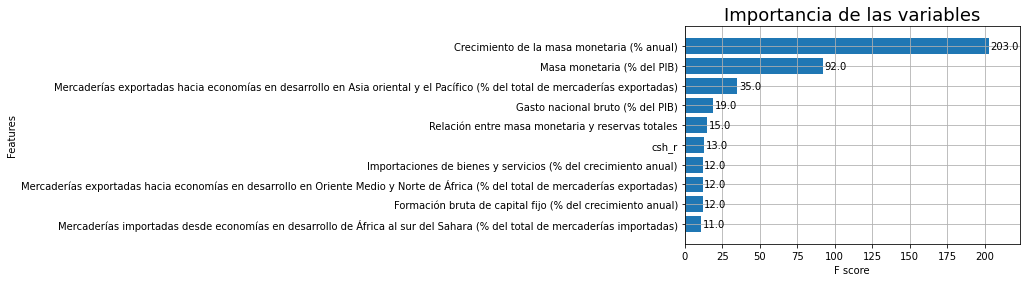

In [13]:
# Graficamos la importancia de unicamente las 10 variables que mas influyen en la predicción
model.get_booster().feature_names = X.columns.tolist()
xgb.plot_importance(model, max_num_features=10, height=0.8)
plt.title('Importancia de las variables', fontsize=18)
plt.show()

Si bien los valores no parecen haber variado, el cambio fue muy leve y las variables por orden de importancia siguen siendo, en su mayoría, las mismas.

Ahora vamos a probar un método automático de eliminación de variables. Este método medirá los residuos por medio de validación cruzada, lo que garantiza mucha precisión.

In [14]:
# Vamos a usar todos los datos para entrenar el selector de variables
# Escalamos los datos
sc = StandardScaler()
X_sc = sc.fit_transform(X)

# Creamos otro modelo de XGBregressor básico.
model = XGBRegressor()

# Creamos el objeto RFECV, que nos permite elegir las variables que mejor se adaptan al modelo.
# El minimo de variables que se deben elegir es 3.
selector = RFECV(model, step=5, cv=4, min_features_to_select=3)

# Entrenamos el modelo con los datos de entrenamiento
selector.fit(X_sc, y)

# Variables que se seleccionaron
print(X.columns[selector.support_][:8])


Index(['Crecimiento de la masa monetaria (% anual)',
       'Mercaderías importadas desde economías en desarrollo dentro de la región (% del total de mercaderías importadas)',
       'Mercaderías exportadas hacia economías en desarrollo en Asia oriental y el Pacífico (% del total de mercaderías exportadas)',
       'Crecimiento de la población rural (% anual)',
       'PIB (US$ a precios constantes de 2010)',
       'Final consumption expenditure (% of GDP)',
       'Formación bruta de capital fijo (% del PIB)',
       'Mercaderías exportadas hacia economías en desarrollo en América Latina y el Caribe (% del total de mercaderías exportadas)'],
      dtype='object')


Las variables que más se relacionan con la inflación (ya sean causa o efecto de la misma) son:
- 'Crecimiento de la masa monetaria (% anual)', 
- 'Mercaderías importadas desde economías en desarrollo dentro de la región (% del total de mercaderías importadas)', 
- 'Mercaderías exportadas hacia economías en desarrollo en Asia oriental y el Pacífico (% del total de mercaderías exportadas)', 
- 'Crecimiento de la población rural (% anual)', 
- 'PIB (US$ a precios constantes de 2010)', 
- 'Final consumption expenditure (% of GDP)'.

Esto significa que tanto positiva como negativamente estas son las variables que más afectan o son afectadas por la inflación. Uno puede argumentar que el crecimiento de la masa monetaria es la causa de la inflación, que las mercancías importadas desde la región se ven disminuidas por la afectación al poder adquisitivo. Que el abaratamiento de las exportaciones motiva a las economías asiáticas a comprar más de Argentina y que por la perdida de valor del dinero mucha gente se ve obligada a dejar el campo y cualquier (y cualquier otra teorización con las demás variables). Sin embargo, ese no es el objetivo de este estudio. Únicamente hemos encontrado las variables que más se relacionan con la inflación. 

Para finalizar se construye un modelo con únicamente las variables seleccionadas.

In [15]:
# Construimos el nuevo modelo con las variables elegidas
X = X[X.columns[selector.support_][:8]]

# Escalamos los datos
X_sc = sc.fit_transform(X)

# Dividemos los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    X_sc, y, test_size=0.33, random_state=0, shuffle=True)

# Creamos otro modelo de XGBregressor básico.
model = XGBRegressor()

# Entrenamos el modelo con los datos de entrenamiento
model.fit(X_train, y_train)


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

Evaluación del modelo con los datos de entrenamiento
MSE: 4.963076208212136e-07
RMSE: 0.0007044910367216985
Evaluación del modelo con los datos de prueba
MSE: 117127.40742582607
RMSE: 342.23881636340735


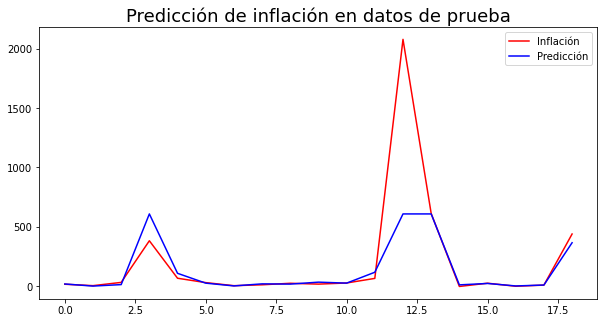

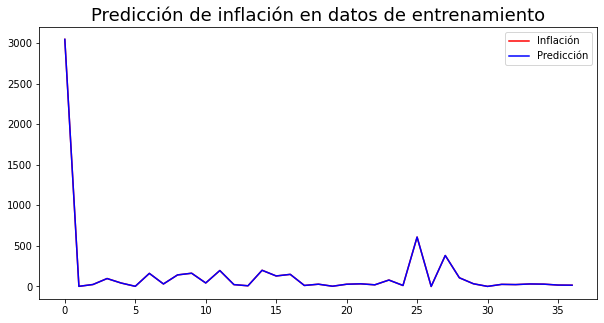

In [16]:
# Evaluamos el modelo con los datos de entrenamiento
y_pred = model.predict(X_train)
print('='*50)
print('Evaluación del modelo con los datos de entrenamiento')
print("MSE:", mean_squared_error(y_train, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_train, y_pred)))
print('='*50)

# Evaluamos el modelo con los datos de prueba
y_pred = model.predict(X_test)
print('Evaluación del modelo con los datos de prueba')
print("MSE:", mean_squared_error(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print('='*50)

# Graficamos el resultado
y_pred = model.predict(X_test)
plt.figure(figsize=(10, 5))
plt.plot(range(len(y_test)), y_test, label='Inflación', color='red')
plt.plot(range(len(y_test)), y_pred, label='Predicción', color='blue')
plt.title('Predicción de inflación en datos de prueba', fontsize=18)
plt.legend()
plt.show()

y_pred = model.predict(X_train)
plt.figure(figsize=(10, 5))
plt.plot(range(len(y_train)), y_train, label='Inflación', color='red')
plt.plot(range(len(y_train)), y_pred, label='Predicción', color='blue')
plt.title('Predicción de inflación en datos de entrenamiento', fontsize=18)
plt.legend()
plt.show()


Aquí podemos observar otro problema, dado que la diferencia en el MSE entre los datos de prueba y entrenamiento es muy grande, es muy probable que el modelo este sobre ajustado. Para poder encontrar la importancia de las variables que sea coherente es necesario corregir esto. Para ello realizamos los siguientes procesos.

In [17]:
model = XGBRegressor()

tuned_parameters = {
    'n_estimators': [100, 400, 500, 600, 1000],
    'max_depth': [4, 5, 6, 7, 8, 9, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
    'min_child_weight': [1, 2, 3, 4, 5],
    'gamma': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7],
}

tuner_model = GridSearchCV(model, param_grid = tuned_parameters, cv=4)
tuner_model.fit(X_train, y_train)

GridSearchCV(cv=4,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    gamma=None, gpu_id=None, grow_policy=None,
                                    importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_bin=None,
                                    max_cat...
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=None,
                              

In [19]:
print(tuner_model.best_params_)
print(tuner_model.best_score_)

{'gamma': 0.0, 'learning_rate': 0.3, 'max_depth': 7, 'min_child_weight': 1, 'n_estimators': 400}
0.5433785009012269


In [20]:
# Vamos a usar los mejores parámetros para entrenar el nuevo modelo
best_params = tuner_model.best_params_
model = XGBRegressor(**best_params)
model.fit(X_train, y_train)


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0.0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.3, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=7, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=400, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

Evaluación del modelo con los datos de entrenamiento
MSE: 3.963020693039288e-07
RMSE: 0.0006295252729668038
Evaluación del modelo con los datos de prueba
MSE: 117103.38249275417
RMSE: 342.2037149020363


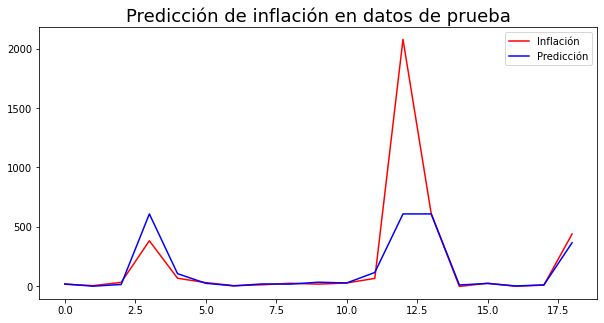

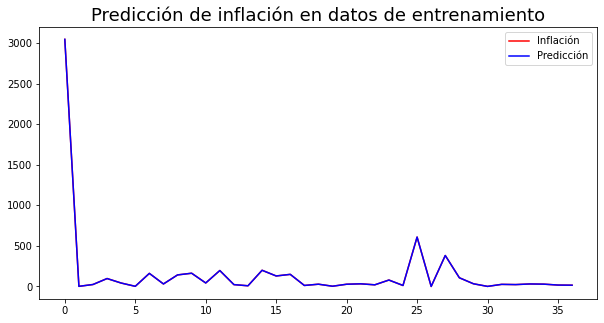

In [21]:
# Evaluamos el modelo con los datos de entrenamiento
y_pred = model.predict(X_train)
print('='*50)
print('Evaluación del modelo con los datos de entrenamiento')
print("MSE:", mean_squared_error(y_train, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_train, y_pred)))
print('='*50)

# Evaluamos el modelo con los datos de prueba
y_pred = model.predict(X_test)
print('Evaluación del modelo con los datos de prueba')
print("MSE:", mean_squared_error(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print('='*50)

# Graficamos el resultado
y_pred = model.predict(X_test)
plt.figure(figsize=(10, 5))
plt.plot(range(len(y_test)), y_test, label='Inflación', color='red')
plt.plot(range(len(y_test)), y_pred, label='Predicción', color='blue')
plt.title('Predicción de inflación en datos de prueba', fontsize=18)
plt.legend()
plt.show()

y_pred = model.predict(X_train)
plt.figure(figsize=(10, 5))
plt.plot(range(len(y_train)), y_train, label='Inflación', color='red')
plt.plot(range(len(y_train)), y_pred, label='Predicción', color='blue')
plt.title('Predicción de inflación en datos de entrenamiento', fontsize=18)
plt.legend()
plt.show()


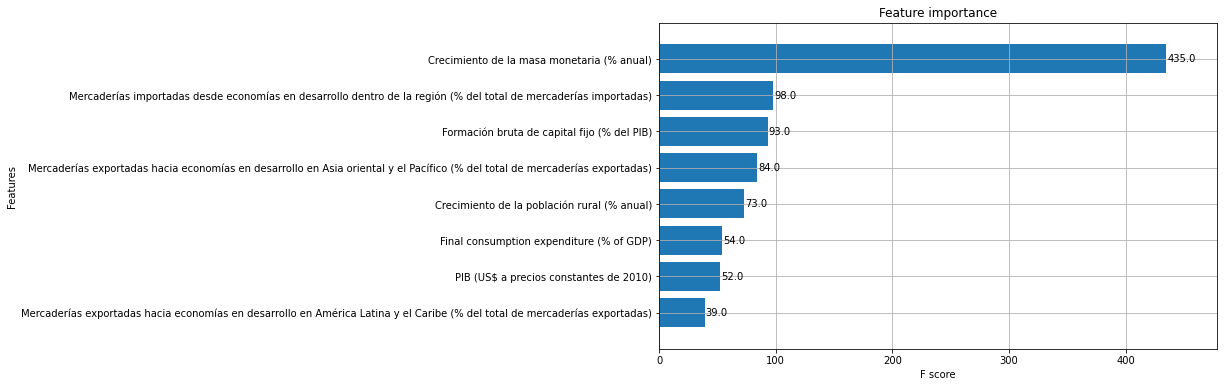

In [29]:
# Vamos a imprimir la importancia de cada variable
model.get_booster().feature_names = X.columns.to_list()
xgb.plot_importance(model, height=0.8)
plt.rcParams["figure.figsize"] = (10, 6)
plt.show()


Así, hemos encontrado que la principal variable económica de Argentina que se relaciona con la inflación es "siempre y en todo lugar" el crecimiento de la masa monetaria (% anual).